In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit import QuantumRegister, ClassicalRegister

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def A_Operator(circuit, f_in, n, theta):
    #Distribution for which we want to estimate Amplitude    
    circuit.ry(theta, f_in[0] )
    circuit.cx( f_in[0], f_in[1] )

In [3]:
def Adagger_Operator(circuit, f_in, n, theta):
    #Complex conjugate of Distribution for which we want to estimate Amplitude
    circuit.cx( f_in[0], f_in[1] )
    circuit.ry(-theta, f_in[0] )

In [4]:
def initial_state(circuit, f_in, f_out, n, m, theta):
    for j in range (m):
        circuit.h( f_out[j] )
    A_Operator(circuit, f_in, n, theta)

In [5]:
def n_controlled_Z( circuit, controls, target):
    #""" Implement a Z gate with multiple controls """
    circuit.h(target)
    circuit.cx(controls, target)
    circuit.h(target)

In [6]:
def inversion_about_average( circuit, f_in, control, n):
    #"""Apply inversion about the average step of Grover's algorithm. """
    # Hadamards everywhere
    for j in range (n):
        circuit.h( f_in[ j ])
    # D matrix : flips the sign of the state |00. . .00> only
    for j in range (n):
        circuit.x( f_in[ j ])
    #n_controlled_Z( circuit, [ f_in[ j ] for j in range (n-1)], f_in[ n-1])
    n_controlled_Z(circuit, control, f_in[ n-1])
    for j in range (n):
        circuit.x( f_in[ j ])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h( f_in[ j ])

In [7]:
#Create Q = A F A† R
def GroversOperator(circuit, f_in, f_out, n, theta, m_index):
    #(qc, f_in, f_out[j], n)
    # Apply controlled R Operator (Do we ever need multi controlled Z????)
    n_controlled_Z(circuit, f_out[m_index], f_in[ n-1])
    # Apply A† Operator
    Adagger_Operator(circuit, f_in, n, theta)
    circuit.barrier(f_in)
    # Apply controlled F Operator
    #inversion_about_average(circuit, f_in, f_out[m_index], n)
    n_controlled_Z(circuit, f_out[m_index], f_in[ n-1])
    circuit.barrier(f_in)
    # Apply A Operator
    A_Operator(circuit, f_in, n, theta)

In [8]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)    
        
    for j in range(n,0,-1):
        print(j)
        qc.h(j-1)
        for m in range(j-1,0,-1):
            print(j,  m)
            qc.cp(-np.pi/float(2**(j-m+1)), m-1, j-1)

1.0471975511965976
3
3 2
3 1
2
2 1
1


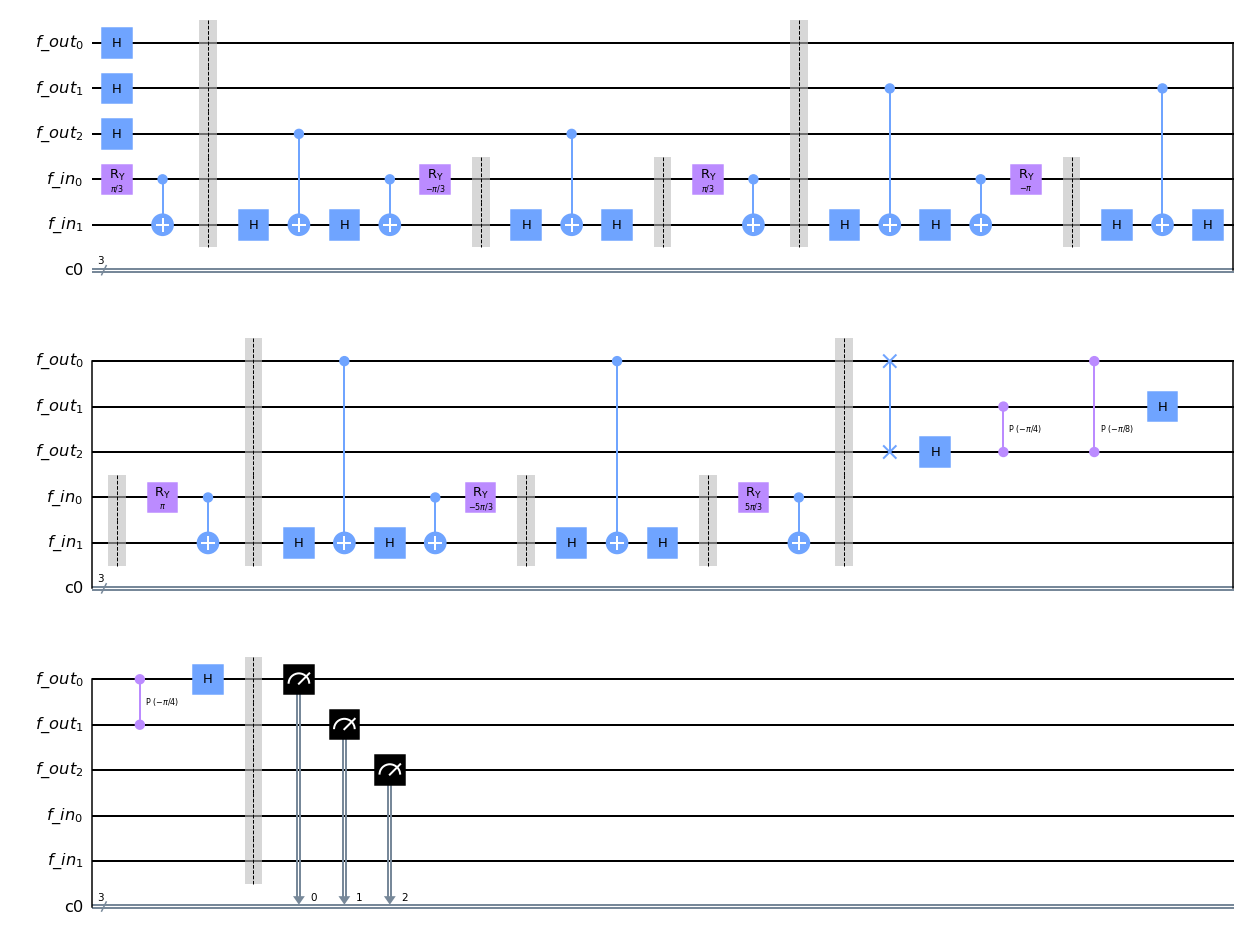

In [9]:
#We want to estimate probability p
p = 0.75

# Make a quantum program for the n-bit Grover search.
n = 2
m = 3

# Define three quantum registers : 'f_in' is the A operator input qubits,
# 'f_out' is qubits used for the sampling and accuracy, aux are the auxiliary bits used.
f_in = QuantumRegister (n, name='f_in')
f_out = QuantumRegister (m, name='f_out')
#aux = QuantumRegister( len(exactly_1_3_satformula) + 1, name='aux')

# One Classical Register to store the result of a measurement
ans = ClassicalRegister(m)
# Create quantum circuit with the quantum and classical registers defined above
qc = QuantumCircuit( f_out, f_in, ans, name='QAE')

#theta = np.pi/4
theta = (2 * np.arcsin(np.sqrt(p)))/2
print(theta)
initial_state(qc, f_in, f_out, n, m, theta)
#insert a Barrier
qc.barrier()

# Apply Q power of 2m iterations
for j in range (m):
    GroversOperator(qc, f_in, f_out, n, (2*j+1)*theta, m-j-1)
    #GroversOperator(qc, f_in, f_out, n, (2**j)*theta, m-j-1)
    qc.barrier()

qft_dagger(qc, m)
qc.barrier()

# Measure the output register in the computational basis
for j in range (m):
    qc.measure(f_out[ j ], ans[ j ])

qc.draw(output='mpl', filename='figure')

In [10]:
#from qiskit_textbook.widgets import scalable_circuit
#scalable_circuit(GroversOperator)

In [12]:
# Create an instance of the local quantum simulator
quantum_simulator = Aer.get_backend ('aer_simulator')       #aer_simulator

# Execute and store the results.
job = execute(qc, quantum_simulator, shots=4096)
result = job.result( )

# Get counts
counts = result.get_counts()
print( ' Observed measurement outcomes : ' )
print( ' string | count ' )
for key in sorted( counts ):
    print( '{:>5s}      {:d}'.format( key, counts[ key ]))

save_histogram = plot_histogram( counts )
save_histogram.show( )
save_histogram.savefig('histogram.png')
#plot_histogram( counts )

 Observed measurement outcomes : 
 string | count 
  000      3039
  100      6
  101      151
  110      292
  111      608
